# 설정

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

이번장에서는 3가지 주제를 가지고 다루어 볼려고 한다. 이는 깊은 심층 신경망을 훈련시킬때 발생하는 문제들이다.
1. 그래디언트 소실 문제를 설명하고 가장 알려진 해결방법을 살펴본다.
2. 대규모 모델의 훈련속도를 크게 높여주는 다양한 최적화 방법을 알아본다.
3. 과대적합(overfit)를 막기위한 규제(regularization)기법을 알아본다.


# 1.그래이던트 소실 폭주 문제

역전파 알고리즘은 출력층에서 입력층으로 오차 그래디언트를 전달시킨다. 그러나 알고리즘이 하위층으로 진행됨에 따라서 그래디어트가 점점 작아지는 현상이 나타날때가 있습니다. 결국 경사하강법이 하위층의 연결 가중치를 실제 변경되지 않은 채로 둔다면 훈련이 좋은 솔루션으로 수렴되지 않습니다. 이 문제를 '그래디언트 소실'이라고 한다. 어떤경우는 반대로 일어난다. 그래디언트가 점점 커져 여러 개의 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산(diverse)하게 된다. 이 문제를 '그래디언트 폭주'라고 하고 주로 순환 신경망(RNN)에서 주로 나타납니다. 

(Understanding the Difficulty of Training Deep Feedforward Neural Networks)에서 로지스틱 시그모이드 활성화 함수와 정규분포의 가중치 초기화 방법을 사용할 때 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 커져 가장 높은 층에서는 활성화 함수가 0또는 1로 수렴하게 된다는 것이다. 이 때문에 그래디언트가 거의 없는 부분이 되고 실재로 아래층에 아무것도 도달되지 않는다.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


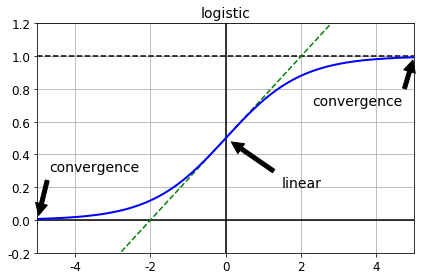

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('convergence', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('convergence', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("logistic", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier와 He 초기화

위에 논문에서 글로럿과 벤지오는 이 문제를 완화시키는 방법을 제안합니다. 정방향과 역방향 즉 양방향의 신호가 적절하게 흘러야 합니다. 적절한 신호가 흐르기 위해서는 출력에 대한 분산값과 입력에 대한 분산값이 같아야 한다고 이야기합니다. 그리고 그래디언트 분산 또한 동일해야 합니다. 사실 층의 입력과 출력 연결 개수가 같지 않다면 이 두가지를 보장할 수 없습니다. 하지만 이들은 실전에서 매우 잘 작동한다고 입증된 대안을 제안합니다. 연결가중치를 다음과 같이 무작위로 초기화 하는 것 입니다.

평균 = 0 , stdev = sqrt(2/(n_input+n_output))인 정규분포 또는 r = sqrt(6/(n_input+n_output))일때 -r과+r사이의 균등분포

또한 다른 활성화 함수에 대해서 활용하는 분포도 존재합니다. 이를 He inialization이라고 합니다.

In [4]:
import tensorflow as tf

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.variance_scaling_initializer() #He 초기화 방식
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## 수렴하지 않는 활성화 함수 

위에 논문의 결과에 따라서 수렴하지 않는 활성화 함수를 쓰는 것이 큰 장점을 가지고 있습니다. 그래서 ReLU를 사용했다. 그러나 ReLU함수는 완벽하지 않습니다. dying ReLU현상이 있습니다. 이는 훈련하는 동안 일부뉴런이 0 이외의 값을 출력하지 않는다는 의미입니다. 특히 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어있기도 합니다. 훈련 도중 뉴런의 가중치가 바뀌어 가중치 합이 음수가 되면 그다음부터 0을 출력하기 시작할 것입니다. ReLU 함수는 입력이 음수면 그래디언트가 0이되기 때문에 이런일이 생기면 뉴런이 다시 살아나기 어렵습니다. 이를 해결하기 위해서 LeakyReLU같은 변종을 사용합니다. 이는 LeakyReLU(z)=max(az,z)로 정의 됩니다. a는 함수의 기울기이고 일반적으로 0.01로 설정합니다. 또한 a값을 무작위로 선택하고 테스트시에는 평균을 사용하는 RReLU도 있다. 마지막으로 a가 훈련되는 동안 학습되는 PReLU도 비교했습니다. 이는 대규모 이미지 데이터셋에는 ReLU보다 성능이 크게 앞섰지만 소규모 데이터셋에서는 훈련세트에 과대적합될 위험이 있습니다. 

### Leaky ReLU

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


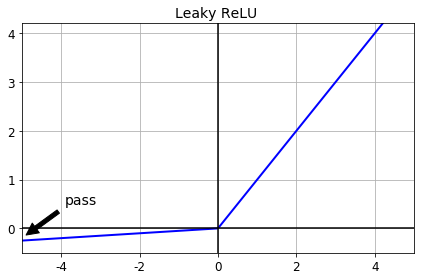

In [10]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('pass', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU ", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

tf에서 LeakyReLU를 구현하기

In [11]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [12]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [13]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [14]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [15]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [16]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [17]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [18]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [22]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [22]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 데이터 정확도: 0.86 검증 세트 정확도: 0.9044
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9494
10 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9656
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.971
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9762
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9772
30 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9782
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9788


### ELU(exponential linear unit)

In [23]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


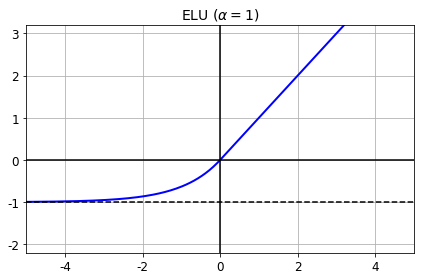

In [25]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [27]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1") #tf.nn.elu

### SELU

이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 [논문](https://arxiv.org/pdf/1706.02515.pdf)에서 소개되었습니다. 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다.

In [29]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


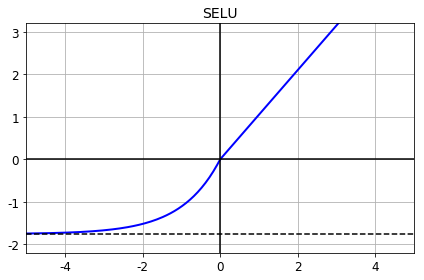

In [30]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [31]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


다음은 텐서플로를 사용한 구현 예입니다(텐서플로 1.4 버전에 `tf.nn.selu()` 함수가 추가되었습니다):

In [32]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELU는 드롭아웃과 연결하여 사용할 수 있습니다. Linz 대학교 생물정보학 연구소(Institute of Bioinformatics)의 Johannes Kepler가 만든 [구현](https://github.com/bioinf-jku/SNNs/blob/master/selu.py)을 확인해 보세요.

SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다:

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

이제 훈련할 차례입니다. 입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [34]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 배치 데이터 정확도: 0.88 검증 세트 정확도: 0.9232
5 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9574
10 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9662
15 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9684
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9692
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.969
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9694
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9702


## 배치 정규화

위에서의 ELU와 HE 초기화를 사용하면 훈련 초기 단계에서 그래디언트소실이나 폭주 문제를 크게 감소시킬 수 있지만, 훈련하는 동안 다시 발생하지 않을 수 없습니다. 그렇기 때문에 그래디언트 소실 및 폭주 문제를 해결하기 위해서 배치정규화batch Normalization(BN)을 제안합니다. 이는 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변화되는 문제입니다.(내부 공변량 변화internal Covariate Shift)

이 방법은 각 층에서 활성화 함수를 통과하기전에 모델에 연산을 하나 추가합니다. 단순하게 입력데이터의 평균을 0으로 만들고  정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킵니다.(p.361) 

테스트 할 떄는 평균과 표준편차를 계산할 미니배치가 없으니 전체 훈련 세트의 평균과 표준편차를 대신 사용합니다. 

전체적으로 보면 배치 정규화된 층마다 스케일, 이동, 평균, 표준편차 네 개의 파라미터가 학습됩니다. 그러나 단점이라면 층마다 추가되는 계산이 신경망의 예측이 느려지게 합니다. 

#### 텐서플로 사용해 배치 정규화 구현 

In [35]:
#tf.layers.batch_normalization()사용

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

#훈련하는 동안에는 True, 이외에서는 False
training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
#training = training_placeholder, momuntum => v' = v'*momentum + v*(1-momentum) :v= 이동평균(지수감소를 이용한)
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)


In [36]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

같은 매개변수를 계속 반복해서 쓰지 않도록 파이썬의 `partial()` 함수를 사용합니다:

In [37]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [39]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
n_epochs = 20
batch_size = 200

노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

In [41]:
'''
1.batch_normalization()함수에 의존하는 어떤 연산을 수행할 때마다 training 플레이스 홀를 True로 설정
2.batch_noramlization()함수는 이동 평균을 갱신하기 위해서 매 훈련 단계에서 평가할 몇개의 연산을 만듭니다. 이 연산은 자동으로 
UPDATE_OPS 컬랙션에 추가되므로 이 컬랙션에서 이 연산들을 뽑아내어 훈련이 반복될 때마다 실행시켜주면 된다.
'''
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9042
1 검증 세트 정확도: 0.928
2 검증 세트 정확도: 0.9374
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9532
5 검증 세트 정확도: 0.9572
6 검증 세트 정확도: 0.9626
7 검증 세트 정확도: 0.9628
8 검증 세트 정확도: 0.9664
9 검증 세트 정확도: 0.968
10 검증 세트 정확도: 0.9694
11 검증 세트 정확도: 0.9696
12 검증 세트 정확도: 0.971
13 검증 세트 정확도: 0.971
14 검증 세트 정확도: 0.9728
15 검증 세트 정확도: 0.9734
16 검증 세트 정확도: 0.9728
17 검증 세트 정확도: 0.975
18 검증 세트 정확도: 0.9752
19 검증 세트 정확도: 0.976


어!? MNIST 정확도가 좋지 않네요. 물론 훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

업데이트 연산에 의존하는 훈련 연산을 만들 수도 있습니다:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

이렇게 하면 훈련할 때 `training_op`만 평가하면 텐서플로가 업데이트 연산도 자동으로 실행할 것입니다:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

한가지 더, 훈련될 변수 개수가 전체 전역 변수 개수보다 적습니다. 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문입니다. 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됩니다.

In [42]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [44]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### 그래디언트 클리핑

그래디언트 폭주문제를 줄이는 쉬운방법은 역전파될 때 일정 임계값을 넘어서지 못하게 그래디언트를 그냥 단순하게 잘라내는 것입니다. 일반적으로는 배치정규화를 선호하지만 이러한 방법도 존재합니다.

텐서플로 옵티마이저의 minimize()함수는 그래디언트 계산과 적용 두가지를 처리합니다. 그래서 compute_gradient() clip_by_value() apply_gradients()가 필요합니다. 

In [45]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [46]:
learning_rate = 0.01

이제 그래디언트 클리핑을 적용합니다. 먼저 그래디언트를 구한 다음 `clip_by_value()` 함수를 사용해 클리핑하고 적용합니다:

In [47]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#gradient값과 variable을 결과값으로 내보냄
grads_and_vars = optimizer.compute_gradients(loss)
# Clips tensor values to a specified min and max.
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
#optimizer에 적용(minimize가 적용되 있다.)
training_op = optimizer.apply_gradients(capped_gvs)

In [48]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [49]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_epochs = 20
batch_size = 200

In [51]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.2878
1 검증 세트 정확도: 0.7942
2 검증 세트 정확도: 0.8794
3 검증 세트 정확도: 0.9054
4 검증 세트 정확도: 0.9162
5 검증 세트 정확도: 0.9212
6 검증 세트 정확도: 0.9292
7 검증 세트 정확도: 0.9358
8 검증 세트 정확도: 0.9378
9 검증 세트 정확도: 0.9414
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.9472
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.9536
14 검증 세트 정확도: 0.9564
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9574
17 검증 세트 정확도: 0.9588
18 검증 세트 정확도: 0.9624
19 검증 세트 정확도: 0.9616


 ## 미리 훈련된 층 사용하기

### 텐서플로 모델 재사용하기

먼저 그래프 구조를 로드해야 합니다. `import_meta_graph()` 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 `Saver` 객체를 반환합니다. 기본적으로 `Saver` 객체는 `.meta` 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 합니다:

In [5]:
reset_graph()

In [7]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

다음 훈련해야될 모든 연산과 텐서를 직접 지정해야 합니다. 그래프 구조를 모를때 모든 연산을 출력해서 볼 수 있습니다.

In [8]:
for op in tf.get_default_graph().get_operations():
    print(op.name)


save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients/loss/SparseSoftmaxCrossEntropyWithLogits

필요한 연산을 찾았다면 그래프의 `get_operation_by_name()`이나 `get_tensor_by_name()` 메서드를 사용하여 추출할 수 있습니다:

In [10]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

원본 모델을 만들 때 다른 사람이 재사용하기 쉽게 연산에 명확한 이름을 부여하고 문서화를 하는 것이 좋습니다. 또 다른 방법은 처리해야 할 중요한 연산들을 모두 모아 놓은 컬렉션을 만드는 것입니다:

In [11]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

이렇게 해서 모델을 재사용할 때 다음과 같이 간단하게 사용할 수 있습니다.

In [12]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

이제 세션을 시작해서 모델을 복원하고 준비된 훈련데이터로 훈련을 할수 있습니다.

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9642
1 검증 세트 정확도: 0.9628
2 검증 세트 정확도: 0.9654
3 검증 세트 정확도: 0.9652
4 검증 세트 정확도: 0.9642
5 검증 세트 정확도: 0.9648
6 검증 세트 정확도: 0.969
7 검증 세트 정확도: 0.9686
8 검증 세트 정확도: 0.9684
9 검증 세트 정확도: 0.9684
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9702
14 검증 세트 정확도: 0.9712
15 검증 세트 정확도: 0.9724
16 검증 세트 정확도: 0.972
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9714
19 검증 세트 정확도: 0.9714


불러오기위한 다른 방법은 원본 그래프를 만든 파이썬 코드에 접근가능하다면 그대로 복사해서 사용하면됩니다. 

In [10]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9642
1 검증 세트 정확도: 0.9628
2 검증 세트 정확도: 0.9654
3 검증 세트 정확도: 0.9652
4 검증 세트 정확도: 0.9642
5 검증 세트 정확도: 0.9648
6 검증 세트 정확도: 0.969
7 검증 세트 정확도: 0.9686
8 검증 세트 정확도: 0.9684
9 검증 세트 정확도: 0.9684
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9702
14 검증 세트 정확도: 0.9712
15 검증 세트 정확도: 0.9724
16 검증 세트 정확도: 0.972
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9714
19 검증 세트 정확도: 0.9714


일반적으로 하위층만 재사용할 것입니다. `import_meta_graph()`를 사용하면 전체 그래프를 로드하지만 필요하지 않은 부분은 무시하면 됩니다. 이 예에서는 학습된 3번째 층 위에 4번째 은닉층을 새로 추가합니다(원래 4번째 층은 무시됩니다). 새로운 출력층도 추가하고 이 출력으로 손실을 계산하고 이를 최소화하기 위한 새로운 옵티마이저를 만듭니다. 전체 그래프(원본 그래프 전체와 새로운 연산)를 저장할 새로운 `Saver` 객체와 새로운 모든 변수를 초기화할 초기화 연산도 필요합니다:

In [23]:
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [24]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.923
1 검증 세트 정확도: 0.945
2 검증 세트 정확도: 0.9534
3 검증 세트 정확도: 0.958
4 검증 세트 정확도: 0.9608
5 검증 세트 정확도: 0.9562
6 검증 세트 정확도: 0.9624
7 검증 세트 정확도: 0.9626
8 검증 세트 정확도: 0.9642
9 검증 세트 정확도: 0.9644
10 검증 세트 정확도: 0.966
11 검증 세트 정확도: 0.9666
12 검증 세트 정확도: 0.9648
13 검증 세트 정확도: 0.968
14 검증 세트 정확도: 0.9676
15 검증 세트 정확도: 0.969
16 검증 세트 정확도: 0.9692
17 검증 세트 정확도: 0.9696
18 검증 세트 정확도: 0.9684
19 검증 세트 정확도: 0.9674


원본 모델을 만든 파이썬 코드에 접근할 수 있다면 필요한 부분만 재사용하고 나머지는 버릴 수 있습니다:

In [25]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

그러나 이전에 학습된 모델을 복원하기 위해 (복원할 변수 리스트를 전달합니다. 그렇지 않으면 그래프와 맞지 않는다고 에러를 낼 것입니다) `Saver` 객체를 하나 만들고 훈련이 끝난 후 새로운 모델을 저장하기 위해 또 다른 `Saver` 객체를 만들어야 합니다:

In [26]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규표현식 변수가져오기 
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt") #위에 해당하는 변수 불러오기

    for epoch in range(n_epochs):                                        
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})    
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "검증 세트 정확도:", accuracy_val)                    

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9018
1 검증 세트 정확도: 0.9324
2 검증 세트 정확도: 0.9432
3 검증 세트 정확도: 0.947
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9532
6 검증 세트 정확도: 0.956
7 검증 세트 정확도: 0.959
8 검증 세트 정확도: 0.9586
9 검증 세트 정확도: 0.9612
10 검증 세트 정확도: 0.9628
11 검증 세트 정확도: 0.9618
12 검증 세트 정확도: 0.9638
13 검증 세트 정확도: 0.9658
14 검증 세트 정확도: 0.9664
15 검증 세트 정확도: 0.9662
16 검증 세트 정확도: 0.9674
17 검증 세트 정확도: 0.9676
18 검증 세트 정확도: 0.968
19 검증 세트 정확도: 0.9674


1. tf.get_default_graph().get_tensor_by_name()
2. tf.get_default_graph().get_operation_by_name()
3. tf.get_collection()

variable

변수 v를 만들면 변수값을 읽고(v/read) 초기값(v/initial_value)을 할당(v/Assign)하는 노드가 각각 그래프에 추가된다.

### 다른 프레임워크의 모델 재사용하기

이 예에서는 재사용하려는 각 변수에 대해 변수 초기화 할당 연산을 찾고, 초기화 될 값에 해당하는 두 번째 입력 핸들을 구합니다. 초기화가 실행될 때 여기에 `feed_dict` 매개변수를 사용하여 초깃값 대신 원하는 값을 주입합니다:

In [28]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [29]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1] #0은 v변수자체 1은 할달될값(v/inital_value)
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


또 다른 방법은 전용 할당 노드와 플레이스홀더를 만든는 것입니다. 이 방법은 더 번거롭고 효율적이지 않지만 하려는 방식이 잘 드러나는 방법입니다:

In [30]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지를 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
with tf.variable_scope("", default_name="", reuse=True):  # 루트 범위
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# 전용 플레이스홀더와 할당 노드를 만듭니다
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


`get_collection()`에 `scope`를 지정하여 변수의 핸들을 가져올 수도 있습니다:

In [31]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

또는 그래프의 `get_tensor_by_name()` 메서드를 사용할 수 있습니다:

In [32]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [33]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 하위층 동결하기

DNN의 하위층은 이미지에 있는 저수준 특성을 감지하도록 되있어서 이층들을 그대로 재사용 하고 싶을 때 하는 방법이 이 층의 가중치를 '동결' 시키는 것입니다. 이러면 상위층의 가중치를 훈련시키기 쉬워집니다. 

1. 하위층의 변수를 제외하고 훈련시킬 변수 목록을 옵티마이저에 전달 

In [34]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [35]:
#var_list로 학습할 변수 목록을 제공하는 방법
#scope='hidden[34]|outputs'=>3,4층의 출력층에 있는 학습할 변수목록을 모두구함
with tf.name_scope("train"):                                         
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [36]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [37]:
#123층의 계산된 변수만을 불러온다.
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.896
1 검증 세트 정확도: 0.9304
2 검증 세트 정확도: 0.9398
3 검증 세트 정확도: 0.9446
4 검증 세트 정확도: 0.9482
5 검증 세트 정확도: 0.9504
6 검증 세트 정확도: 0.9506
7 검증 세트 정확도: 0.9536
8 검증 세트 정확도: 0.9552
9 검증 세트 정확도: 0.9564
10 검증 세트 정확도: 0.956
11 검증 세트 정확도: 0.9566
12 검증 세트 정확도: 0.9568
13 검증 세트 정확도: 0.9572
14 검증 세트 정확도: 0.959
15 검증 세트 정확도: 0.9576
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9598
18 검증 세트 정확도: 0.959
19 검증 세트 정확도: 0.9598


2.stop_gradient()층을 추가하는 것 이렇게 하면 이 층 아래의 모든 층이 고정된다.

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [39]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [40]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [41]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9022
1 검증 세트 정확도: 0.9306
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9514
5 검증 세트 정확도: 0.9522
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9556
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.956
10 검증 세트 정확도: 0.9572
11 검증 세트 정확도: 0.955
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.958
14 검증 세트 정확도: 0.9582
15 검증 세트 정확도: 0.958
16 검증 세트 정확도: 0.9566
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.9588


### 동결된층 캐싱하기

2번째층까지 동결되있기 때문에 앞서 처음부터 미니배치를 통해서 뿌려주기보다 한번에 2번째 층까지의 출력을 받고 그 출력을 미니배치하여 주입하면 속도가 빨라진다. 

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

NameError: name 'learning_rate' is not defined

In [43]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, 
                                                y: y_valid})             
        print(epoch, "검증 세트 정확도:", accuracy_val)            

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9022
1 검증 세트 정확도: 0.9306
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9514
5 검증 세트 정확도: 0.9522
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9556
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.956
10 검증 세트 정확도: 0.9572
11 검증 세트 정확도: 0.955
12 검증 세트 정확도: 0.9574
13 검증 세트 정확도: 0.958
14 검증 세트 정확도: 0.9582
15 검증 세트 정확도: 0.958
16 검증 세트 정확도: 0.9566
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.9588


#  고속 옵티마이져

### 모멘텀 옵티

In [11]:
import tensorflow as tf
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

### 네스테로프 가속 경사

In [12]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### AdaGrad

In [13]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### RMSProp

In [15]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

### Adam 최적화

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### 학습률 스케줄링

In [18]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [19]:
with tf.name_scope("train"):       
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9574
1 검증 세트 정확도: 0.9716
2 검증 세트 정확도: 0.973
3 검증 세트 정확도: 0.9798
4 검증 세트 정확도: 0.9816


# 규제(Regularizer)

## $\ell_1$과 $\ell_2$ 규제

L1규제에 대한 기본적인 방법으로 먼저 평상시의 모델을 만듭니다.

In [27]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

다음으로 규제를 가할 곳을 계산합니다.

In [28]:
W1 = tf.get_default_gㅡph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [29]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.831
1 검증 세트 정확도: 0.871
2 검증 세트 정확도: 0.8838
3 검증 세트 정확도: 0.8934
4 검증 세트 정확도: 0.8966
5 검증 세트 정확도: 0.8988
6 검증 세트 정확도: 0.9016
7 검증 세트 정확도: 0.9044
8 검증 세트 정확도: 0.9058
9 검증 세트 정확도: 0.906
10 검증 세트 정확도: 0.9068
11 검증 세트 정확도: 0.9054
12 검증 세트 정확도: 0.907
13 검증 세트 정확도: 0.9084
14 검증 세트 정확도: 0.9088
15 검증 세트 정확도: 0.9064
16 검증 세트 정확도: 0.9068
17 검증 세트 정확도: 0.9066
18 검증 세트 정확도: 0.9066
19 검증 세트 정확도: 0.9052


다른 방법으로 변수를 생성하는 함수(get_variable, tf.layer.dense)는 각 변수에 대한 매개변수(*_regularizer)를 제공합니다. 그리고 가중치를 받아서 규제에 맞는 손실을 반환하는 함수도 이 매개변수에 전달할 수 있습니다. 이는 l1_regularizer(), l2_regularizer(), l1_l2_regularizer() 함수가 있습니다.

In [30]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [37]:
scale = 0.001

from functools import partial

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)) 
#kernel_regularizer를 통해서 규제에 대한 함수를 받아쓴다. 

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    

In [38]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy") 
    #규제손실을 포함하고 있는 특별한 컬렉션에서 규제손실을 가져온다.(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [40]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.8274
1 검증 세트 정확도: 0.8766
2 검증 세트 정확도: 0.8952
3 검증 세트 정확도: 0.9016
4 검증 세트 정확도: 0.908
5 검증 세트 정확도: 0.9096
6 검증 세트 정확도: 0.9124
7 검증 세트 정확도: 0.9154
8 검증 세트 정확도: 0.9178
9 검증 세트 정확도: 0.919
10 검증 세트 정확도: 0.92
11 검증 세트 정확도: 0.9224
12 검증 세트 정확도: 0.9212
13 검증 세트 정확도: 0.9228
14 검증 세트 정확도: 0.9222
15 검증 세트 정확도: 0.9218
16 검증 세트 정확도: 0.9218
17 검증 세트 정확도: 0.9228
18 검증 세트 정확도: 0.9216
19 검증 세트 정확도: 0.9214


# 드롭아웃

In [42]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [43]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [44]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9258
1 검증 세트 정확도: 0.945
2 검증 세트 정확도: 0.9488
3 검증 세트 정확도: 0.9576
4 검증 세트 정확도: 0.9612
5 검증 세트 정확도: 0.9618
6 검증 세트 정확도: 0.962
7 검증 세트 정확도: 0.9668
8 검증 세트 정확도: 0.968
9 검증 세트 정확도: 0.97
10 검증 세트 정확도: 0.9692
11 검증 세트 정확도: 0.9698
12 검증 세트 정확도: 0.9712
13 검증 세트 정확도: 0.9718
14 검증 세트 정확도: 0.9712
15 검증 세트 정확도: 0.9692
16 검증 세트 정확도: 0.971
17 검증 세트 정확도: 0.9732
18 검증 세트 정확도: 0.9724
19 검증 세트 정확도: 0.9726


## 맥스-노름 규제 

간단한 2개층을 가진 mnist 

In [46]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

가중치에 대한 핸들을 얻고 `clip_by_norm()` 함수를 사용해 가중치를 클리핑하는 연산을 만듭니다. 그런 다음 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듭니다:

In [47]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [48]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [49]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

이제 모델을 훈련시킵니다. 이전과 매우 동일한데 `training_op`을 실행한 후에 `clip_weights`와 `clip_weights2` 연산을 실행하는 것만 다릅니다:

훈련 한번 할 때마다 가중지에 대해서 맥스노름을 실행시켜주면 됩니다.

In [50]:
n_epochs = 20
batch_size = 50

In [51]:
with tf.Session() as sess:                                              
    init.run()                                                          
    for epoch in range(n_epochs):                                       
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):  
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "검증 세트 정확도:", accuracy_val)                    

    save_path = saver.save(sess, "./my_model_final.ckpt")               

0 검증 세트 정확도: 0.9568
1 검증 세트 정확도: 0.97
2 검증 세트 정확도: 0.9708
3 검증 세트 정확도: 0.9774
4 검증 세트 정확도: 0.977
5 검증 세트 정확도: 0.9786
6 검증 세트 정확도: 0.982
7 검증 세트 정확도: 0.9822
8 검증 세트 정확도: 0.9802
9 검증 세트 정확도: 0.9818
10 검증 세트 정확도: 0.9828
11 검증 세트 정확도: 0.9846
12 검증 세트 정확도: 0.9828
13 검증 세트 정확도: 0.9838
14 검증 세트 정확도: 0.9844
15 검증 세트 정확도: 0.9848
16 검증 세트 정확도: 0.9842
17 검증 세트 정확도: 0.984
18 검증 세트 정확도: 0.9848
19 검증 세트 정확도: 0.985


이보다 더 좋은 방법은 max_norm_regularizer()함수는 만드는 것입니다.

In [53]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

그런 다음 (필요한 임계값을 지정해서) 맥스 노름 규제 매개변수에 넘길 함수를 만들기 위해 이 함수를 호출합니다. 은닉층을 만들 때 이 규제 함수를 `kernel_regularizer` 매개변수를 통해 전달할 수 있습니다:

In [54]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [55]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [56]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [57]:
n_epochs = 20
batch_size = 50

In [1]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "검증 세트 정확도:", accuracy_val)                    

    save_path = saver.save(sess, "./my_model_final.ckpt")                

NameError: name 'tf' is not defined